<a href="https://colab.research.google.com/github/pk2971/Air-Quality-time-series/blob/main/Air_Quality_vs_Temperature_time_series_forecasting.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Air Quality vs Temperature Time Series Forecasting.**


Author: Praharshita Kaithepalli(pk2971@rit.edu)


Data Set:https://archive.ics.uci.edu/ml/datasets/Air+Quality 

Pollutants/Greenhouse gasses in the air often cause a rise in the temperature at any given time of the day. 
As the day progresses and the traffic increases during a certain time of the day there might be more pollutants in the air(for example during the morning rush hours or when everyone is going back to homes or during the factorys working hours). Our goal is to see if we can predict the amount of pollutants in the air, temperature by studying the patterns across different times.


In [179]:
import pandas as pd
import io
import csv

In [180]:
#from google.colab import drive
#drive.mount('/gdrive',force_remount=True)
#%cd /gdrive

In [181]:
df=pd.read_csv("/content/AirQualityUCI.csv",sep=';',decimal='.',quoting=csv.QUOTE_NONE, skip_blank_lines=False)

In [182]:
import pandas as pd
import numpy as np
import csv
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense,Dropout
from tensorflow.keras.losses import MeanSquaredError as mse
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [183]:
#Dropping unnamed columns
df=df.drop(['Unnamed: 15','Unnamed: 16'],axis=1)

In the data set date and time are in seperate columns. We will convert them into datetime data type and then concatenate them.

In [184]:
from datetime import datetime as dt
df['Time'] = pd.to_datetime(df['Time'], format='%H.%M.%S' ).dt.time
df['Date']=pd.to_datetime(df['Date'],format='%d/%m/%Y')

In [185]:
df['DateTime']=pd.to_datetime(df.Date.astype(str) + ' ' + df.Time.astype(str),errors='coerce')

Some columns which are supposed to have float data type are in object data type and there is a "," instead of the decimal point.

In [186]:
df['CO(GT)']=df['CO(GT)'].str.replace(",",".")
df['CO(GT)']=df['CO(GT)'].astype(float)

In [187]:
df['C6H6(GT)']=df['C6H6(GT)'].str.replace(",",".")
df['C6H6(GT)']=df['C6H6(GT)'].astype(float)

In [188]:
df['T']=df['T'].str.replace(",",".")
df['T']=df['T'].astype(float)

In [189]:
df['RH']=df['RH'].str.replace(",",".")
df['RH']=df['RH'].astype(float)

In [190]:
df['AH']=df['AH'].str.replace(",",".")
df['AH']=df['AH'].astype(float)

In [191]:
df=df.dropna()

**Exploratory Data Analysis:**

Performing EDA to understand how the data is distributed across Date and time. 

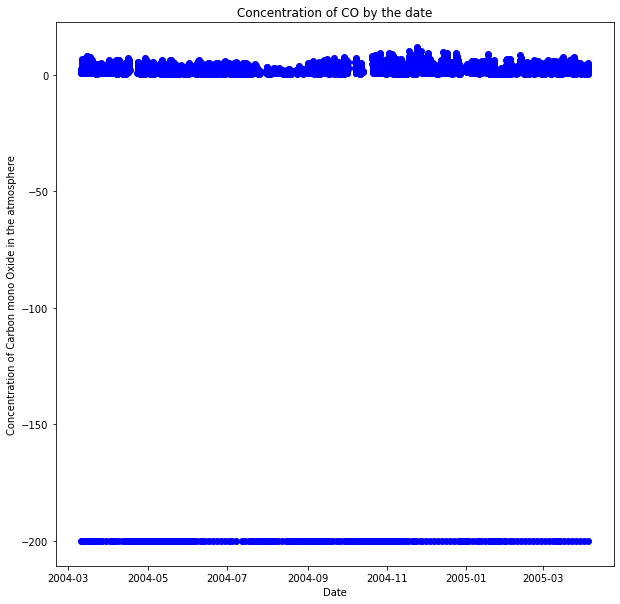

In [192]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df['DateTime'],df['CO(GT)'],color='blue')
ax.set(xlabel="Date",
       ylabel="Concentration of Carbon mono Oxide in the atmosphere",
       title="Concentration of CO by the date")

plt.show()

Intersting observations here. There seems to be outliers in the data. Especially the value -200. Checking one more column to find out if there is similar outlier data.

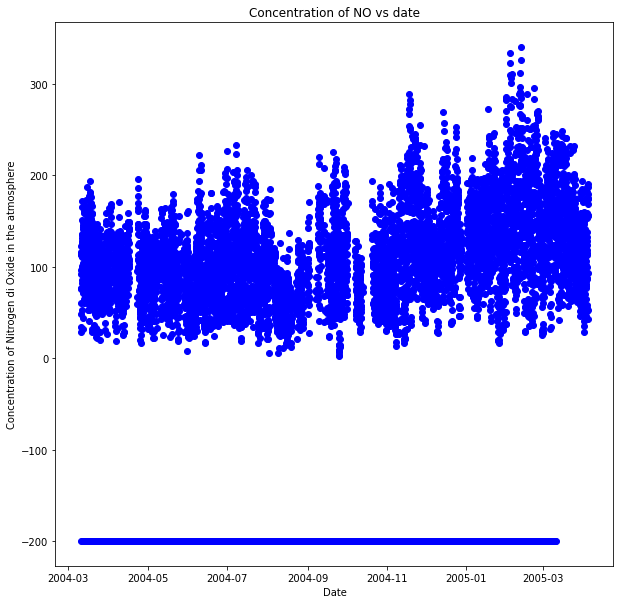

In [193]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df['DateTime'],df['NO2(GT)'],color='blue')
ax.set(xlabel="Date",
       ylabel="Concentration of Nitrogen di Oxide in the atmosphere",
       title="Concentration of NO vs date")

plt.show()

The outlier data is present in this column as well. 

Checking if there is outlier data specifically -200 in all the other columns.


In [194]:
print((df['CO(GT)']==-200).sum())

1683


In [195]:
#removing fields with -200 as value.
df=df[df['CO(GT)']!=-200]

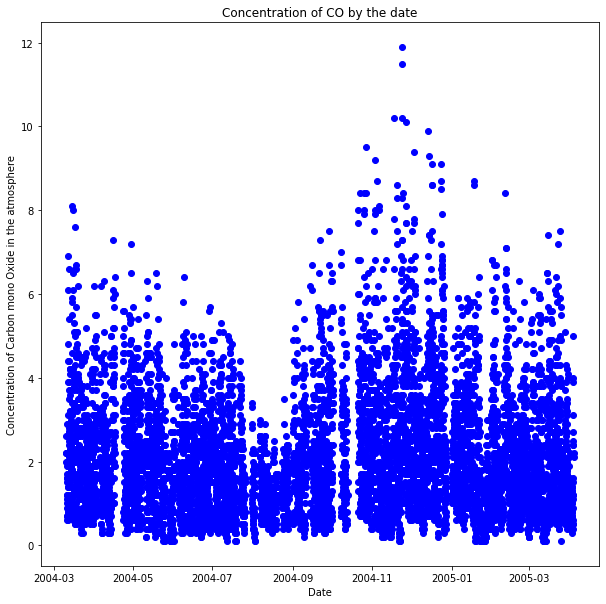

In [196]:
#plotting the data points again after cleaning.
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df['DateTime'],df['CO(GT)'],color='blue')
ax.set(xlabel="Date",
       ylabel="Concentration of Carbon mono Oxide in the atmosphere",
       title="Concentration of CO by the date")

plt.show()

We can see that the outliers have been removed. 

In [197]:
print ("PT08.S1(CO) ",(df['PT08.S1(CO)']==-200).sum())
print("NMHC(GT) ",(df['NMHC(GT)']==-200).sum())
print("C6H6(GT) ",(df['C6H6(GT)']==-200).sum())
print("PT08.S2(NMHC)",(df['PT08.S2(NMHC)']==-200).sum())
print("NO2(GT)",(df['NO2(GT)']==-200).sum())
print("PT08.S4(NO2)",(df['PT08.S4(NO2)']==-200).sum())
print("PT08.S5(O3)",(df['PT08.S5(O3)']==-200).sum())
print("T",(df['T']==-200).sum())
print("RH",(df['RH']==-200).sum())
print("AH",(df['AH']==-200).sum())

PT08.S1(CO)  330
NMHC(GT)  6784
C6H6(GT)  330
PT08.S2(NMHC) 330
NO2(GT) 416
PT08.S4(NO2) 330
PT08.S5(O3) 330
T 330
RH 330
AH 330


In [198]:
del df['NMHC(GT)']
#Too many outlier values we will drop the whole column as there is no use fixing the outlier.

Removing the outlier and replacing it with mean/median value in the rest of the columns.

In [199]:
median=df.loc[df['PT08.S1(CO)']!=-200,'PT08.S1(CO)'].median()
df.loc[df['PT08.S1(CO)']==-200,'PT08.S1(CO)']=np.nan
df['PT08.S1(CO)'].fillna(median,inplace=True)
median

1075.0

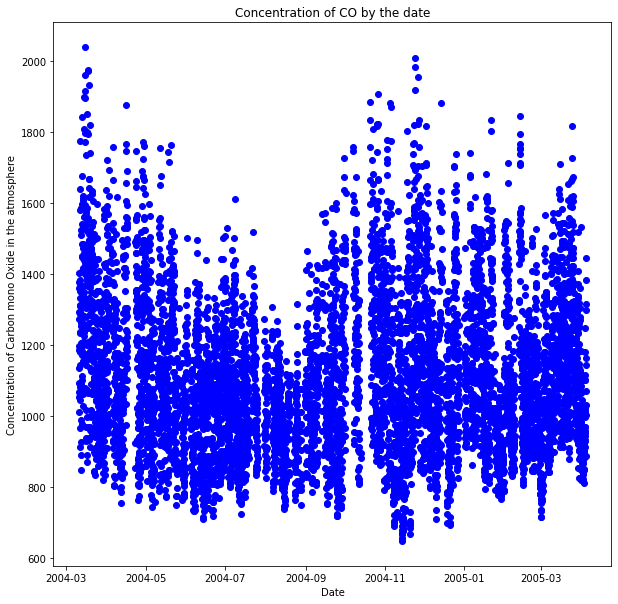

In [200]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df['DateTime'],df['PT08.S1(CO)'],color='blue')
ax.set(xlabel="Date",
       ylabel="Concentration of Carbon mono Oxide in the atmosphere",
       title="Concentration of CO by the date")

plt.show()

In [201]:
median=df.loc[df['C6H6(GT)']!=-200,'C6H6(GT)'].median()
df.loc[df['C6H6(GT)']==-200,'C6H6(GT)']=np.nan
df['C6H6(GT)'].fillna(median,inplace=True)
median

8.5

In [202]:
median=df.loc[df['PT08.S2(NMHC)']!=-200,'PT08.S2(NMHC)'].median()
df.loc[df['PT08.S2(NMHC)']==-200,'PT08.S2(NMHC)']=np.nan
df['PT08.S2(NMHC)'].fillna(median,inplace=True)
median

919.0

In [203]:
median=df.loc[df['NOx(GT)']!=-200,'NOx(GT)'].median()
df.loc[df['NOx(GT)']==-200,'NOx(GT)']=np.nan
df['NOx(GT)'].fillna(median,inplace=True)
median

188.0

In [204]:
median=df.loc[df['PT08.S3(NOx)']!=-200,'PT08.S3(NOx)'].median()
df.loc[df['PT08.S3(NOx)']==-200,'PT08.S3(NOx)']=np.nan
df['PT08.S3(NOx)'].fillna(median,inplace=True)
median

795.0

In [205]:
median=df.loc[df['NO2(GT)']!=-200,'NO2(GT)'].median()
df.loc[df['NO2(GT)']==-200,'NO2(GT)']=np.nan
df['NO2(GT)'].fillna(median,inplace=True)
median

110.0

In [206]:
median=df.loc[df['PT08.S4(NO2)']!=-200,'PT08.S4(NO2)'].median()
df.loc[df['PT08.S4(NO2)']==-200,'PT08.S4(NO2)']=np.nan
df['PT08.S4(NO2)'].fillna(median,inplace=True)
median

1447.0

In [207]:
median=df.loc[df['PT08.S5(O3)']!=-200,'PT08.S5(O3)'].median()
df.loc[df['PT08.S5(O3)']==-200,'PT08.S5(O3)']=np.nan
df['PT08.S5(O3)'].fillna(median,inplace=True)
median

990.0

In [208]:
mean=df.loc[df['T']!=-200,'T'].mean()
df.loc[df['T']==-200,'T']=np.nan
df['T'].fillna(mean,inplace=True)
mean

17.770424836601407

In [209]:
mean=df.loc[df['AH']!=-200,'AH'].mean()
df.loc[df['AH']==-200,'AH']=np.nan
df['AH'].fillna(mean,inplace=True)
mean

0.9894533088235242

In [210]:
mean=df.loc[df['RH']!=-200,'RH'].mean()
df.loc[df['RH']==-200,'RH']=np.nan
df['RH'].fillna(mean,inplace=True)
mean

49.06007625272324

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7674 entries, 0 to 9356
Data columns (total 15 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           7674 non-null   datetime64[ns]
 1   Time           7674 non-null   object        
 2   CO(GT)         7674 non-null   float64       
 3   PT08.S1(CO)    7674 non-null   float64       
 4   C6H6(GT)       7674 non-null   float64       
 5   PT08.S2(NMHC)  7674 non-null   float64       
 6   NOx(GT)        7674 non-null   float64       
 7   PT08.S3(NOx)   7674 non-null   float64       
 8   NO2(GT)        7674 non-null   float64       
 9   PT08.S4(NO2)   7674 non-null   float64       
 10  PT08.S5(O3)    7674 non-null   float64       
 11  T              7674 non-null   float64       
 12  RH             7674 non-null   float64       
 13  AH             7674 non-null   float64       
 14  DateTime       7674 non-null   datetime64[ns]
dtypes: datetime64[ns](2),

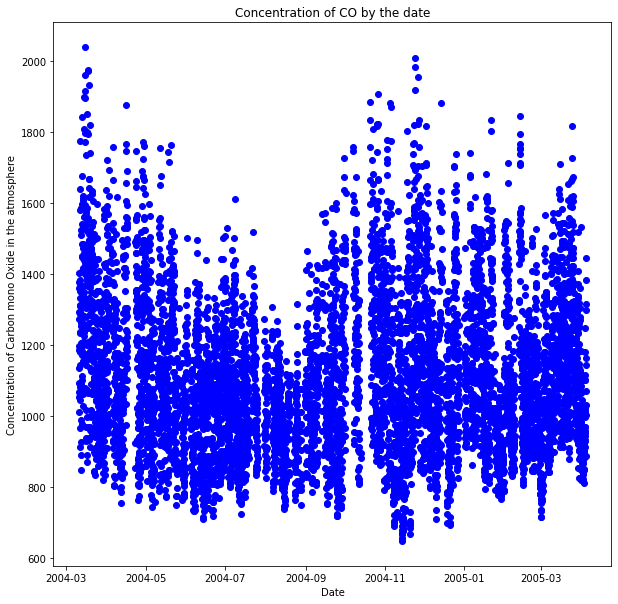

In [212]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.scatter(df['DateTime'],df['PT08.S1(CO)'],color='blue')
ax.set(xlabel="Date",
       ylabel="Concentration of Carbon mono Oxide in the atmosphere",
       title="Concentration of CO by the date")

plt.show()

In [213]:
df=df.dropna()

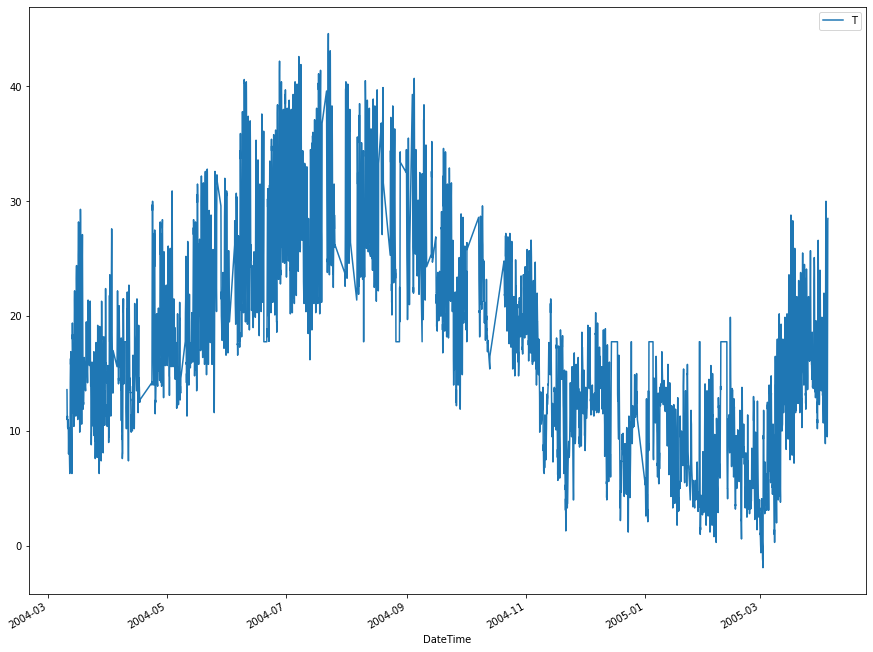

In [214]:
df.plot(x='DateTime',y='T',figsize=(15,12))

Converting the DateTime column into the index of the data set to better enable it for a time series forecasting.

In [215]:
df.index=df.pop('DateTime')

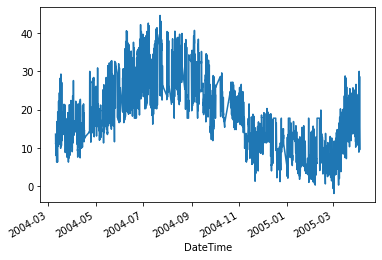

In [216]:
#Plotting the temperature against time is easier now.
temp=df['T']
temp.plot()

In [217]:
temp.head(15)

DateTime
2004-03-10 18:00:00    13.6
2004-03-10 19:00:00    13.3
2004-03-10 20:00:00    11.9
2004-03-10 21:00:00    11.0
2004-03-10 22:00:00    11.2
2004-03-10 23:00:00    11.2
2004-03-11 00:00:00    11.3
2004-03-11 01:00:00    10.7
2004-03-11 02:00:00    10.7
2004-03-11 03:00:00    10.3
2004-03-11 05:00:00    11.0
2004-03-11 06:00:00    10.5
2004-03-11 07:00:00    10.2
2004-03-11 08:00:00    10.8
2004-03-11 09:00:00    10.5
Name: T, dtype: float64

In [218]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7674 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   Date           7674 non-null   datetime64[ns]
 1   Time           7674 non-null   object        
 2   CO(GT)         7674 non-null   float64       
 3   PT08.S1(CO)    7674 non-null   float64       
 4   C6H6(GT)       7674 non-null   float64       
 5   PT08.S2(NMHC)  7674 non-null   float64       
 6   NOx(GT)        7674 non-null   float64       
 7   PT08.S3(NOx)   7674 non-null   float64       
 8   NO2(GT)        7674 non-null   float64       
 9   PT08.S4(NO2)   7674 non-null   float64       
 10  PT08.S5(O3)    7674 non-null   float64       
 11  T              7674 non-null   float64       
 12  RH             7674 non-null   float64       
 13  AH             7674 non-null   float64       
dtypes: datetime64[ns](1), float64(12), o

Now we get to the time series prediction. We split the Temperature column.

For example: 

t[1] t[2] t[3] t[4] t[5]-->t[6](t[6] is predicted by the first 5 data points) 

t[6] t[7] t[8] t[9] t[10]-->t[11]

t[11] t[12] t[13] t[14] t[15]-->t[16]


In [219]:
def df_to_X_y(df,window_size=5):
  df_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_np)-window_size):
    row = [[a] for a in df_np[i:i+window_size]]
    X.append(row)
    label = df_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)


In [220]:
WINDOW_SIZE = 5
X1, y1 = df_to_X_y(temp, WINDOW_SIZE)
X1.shape, y1.shape

((7669, 5, 1), (7669,))

Splitting the data into training, testing and validation sets.

In [221]:
X_train1, y_train1 = X1[:5000], y1[:5000]
X_val1, y_val1 = X1[5000:5500], y1[5000:5500]
X_test1, y_test1 = X1[5500:], y1[5500:]
X_train1.shape, y_train1.shape, X_val1.shape, y_val1.shape, X_test1.shape, y_test1.shape

((5000, 5, 1), (5000,), (500, 5, 1), (500,), (2169, 5, 1), (2169,))

Model 1: LSTM

In [222]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

model1 = Sequential()
model1.add(InputLayer((5, 1)))
model1.add(LSTM(64))
model1.add(Dense(8, 'relu'))
model1.add(Dense(1, 'linear'))

model1.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 64)                16896     
                                                                 
 dense_8 (Dense)             (None, 8)                 520       
                                                                 
 dense_9 (Dense)             (None, 1)                 9         
                                                                 
Total params: 17,425
Trainable params: 17,425
Non-trainable params: 0
_________________________________________________________________


In [223]:
#Optimizer=Adam
cp1 = ModelCheckpoint('model1/', save_best_only=True)
model1.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [224]:
model1.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=15, callbacks=[cp1])

Epoch 1/15
157/157 [==============================] - ETA: 0s - loss: 464.8145 - root_mean_squared_error: 21.5596

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


157/157 [==============================] - 8s 39ms/step - loss: 464.8145 - root_mean_squared_error: 21.5596 - val_loss: 103.7058 - val_root_mean_squared_error: 10.1836
Epoch 2/15
153/157 [============================>.] - ETA: 0s - loss: 355.8687 - root_mean_squared_error: 18.8645

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


157/157 [==============================] - 6s 36ms/step - loss: 354.3890 - root_mean_squared_error: 18.8252 - val_loss: 51.5757 - val_root_mean_squared_error: 7.1816
Epoch 3/15
147/157 [===========================>..] - ETA: 0s - loss: 249.3626 - root_mean_squared_error: 15.7912

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


157/157 [==============================] - 5s 32ms/step - loss: 247.9843 - root_mean_squared_error: 15.7475 - val_loss: 24.2110 - val_root_mean_squared_error: 4.9205
Epoch 4/15
148/157 [===========================>..] - ETA: 0s - loss: 171.2294 - root_mean_squared_error: 13.0855

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


157/157 [==============================] - 6s 38ms/step - loss: 170.0103 - root_mean_squared_error: 13.0388 - val_loss: 18.1221 - val_root_mean_squared_error: 4.2570
Epoch 5/15
157/157 [==============================] - 1s 5ms/step - loss: 121.4036 - root_mean_squared_error: 11.0183 - val_loss: 21.1478 - val_root_mean_squared_error: 4.5987
Epoch 6/15
151/157 [===========================>..] - ETA: 0s - loss: 91.7309 - root_mean_squared_error: 9.5776

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


157/157 [==============================] - 6s 37ms/step - loss: 91.2126 - root_mean_squared_error: 9.5505 - val_loss: 13.8361 - val_root_mean_squared_error: 3.7197
Epoch 7/15
157/157 [==============================] - ETA: 0s - loss: 67.5984 - root_mean_squared_error: 8.2218

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


157/157 [==============================] - 5s 32ms/step - loss: 67.5984 - root_mean_squared_error: 8.2218 - val_loss: 6.4417 - val_root_mean_squared_error: 2.5380
Epoch 8/15
150/157 [===========================>..] - ETA: 0s - loss: 50.8434 - root_mean_squared_error: 7.1305

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


157/157 [==============================] - 6s 37ms/step - loss: 50.4805 - root_mean_squared_error: 7.1050 - val_loss: 2.6634 - val_root_mean_squared_error: 1.6320
Epoch 9/15
157/157 [==============================] - ETA: 0s - loss: 37.9133 - root_mean_squared_error: 6.1574

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


157/157 [==============================] - 5s 33ms/step - loss: 37.9133 - root_mean_squared_error: 6.1574 - val_loss: 2.3812 - val_root_mean_squared_error: 1.5431
Epoch 10/15
156/157 [============================>.] - ETA: 0s - loss: 29.6940 - root_mean_squared_error: 5.4492

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


157/157 [==============================] - 6s 37ms/step - loss: 29.6926 - root_mean_squared_error: 5.4491 - val_loss: 1.9476 - val_root_mean_squared_error: 1.3956
Epoch 11/15
157/157 [==============================] - ETA: 0s - loss: 23.4634 - root_mean_squared_error: 4.8439

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


157/157 [==============================] - 5s 33ms/step - loss: 23.4634 - root_mean_squared_error: 4.8439 - val_loss: 1.8281 - val_root_mean_squared_error: 1.3521
Epoch 12/15
145/157 [==========================>...] - ETA: 0s - loss: 18.9830 - root_mean_squared_error: 4.3570

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


157/157 [==============================] - 6s 36ms/step - loss: 18.7799 - root_mean_squared_error: 4.3336 - val_loss: 1.5130 - val_root_mean_squared_error: 1.2300
Epoch 13/15
152/157 [============================>.] - ETA: 0s - loss: 15.2477 - root_mean_squared_error: 3.9048

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


157/157 [==============================] - 6s 40ms/step - loss: 15.3530 - root_mean_squared_error: 3.9183 - val_loss: 1.3834 - val_root_mean_squared_error: 1.1762
Epoch 14/15
157/157 [==============================] - 1s 5ms/step - loss: 12.7399 - root_mean_squared_error: 3.5693 - val_loss: 1.4116 - val_root_mean_squared_error: 1.1881
Epoch 15/15
156/157 [============================>.] - ETA: 0s - loss: 10.7055 - root_mean_squared_error: 3.2719

INFO:tensorflow:Assets written to: model1/assets


INFO:tensorflow:Assets written to: model1/assets


157/157 [==============================] - 5s 33ms/step - loss: 10.6939 - root_mean_squared_error: 3.2702 - val_loss: 1.2844 - val_root_mean_squared_error: 1.1333


In [225]:
from tensorflow.keras.models import load_model
model1 = load_model('model1/')

Model 1:Predicted data using X_train1 vs data in y_train1.




In [226]:
train_predictions = model1.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

,Train Predictions,Actuals
0,11.195223,11.2
1,11.219095,11.3
2,11.337233,10.7
3,10.803013,10.7
4,10.749197,10.3
...,...,...
4995,12.163568,12.5
4996,12.580725,12.6
4997,12.682588,12.5
4998,12.573186,13.1


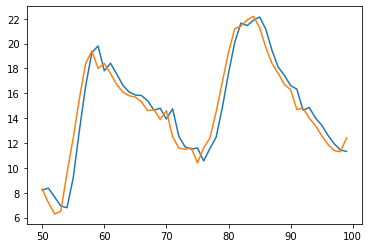

In [227]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

Model 2:Predicted data using validation data set X_val1 vs data in y_val1.


In [228]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

,Val Predictions,Actuals
0,13.302912,13.3
1,13.407048,13.3
2,13.391825,12.7
3,12.760946,11.9
4,11.964886,11.8
...,...,...
495,11.827999,12.0
496,12.043308,11.2
497,11.295017,11.5
498,11.521993,11.6


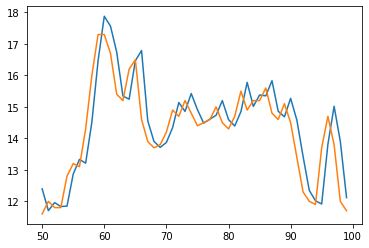

In [229]:
import matplotlib.pyplot as plt
plt.plot(val_results['Val Predictions'][50:100])
plt.plot(val_results['Actuals'][50:100])

Model 1:Predicted data using X_test1 vs data in y_test1.





In [230]:
test_predictions = model1.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

,Test Predictions,Actuals
0,11.553771,11.7
1,11.742535,11.9
2,11.946907,12.5
3,12.569130,12.3
4,12.380579,11.5
...,...,...
2164,19.121035,21.9
2165,22.631603,24.3
2166,24.370794,26.9
2167,26.209431,28.3


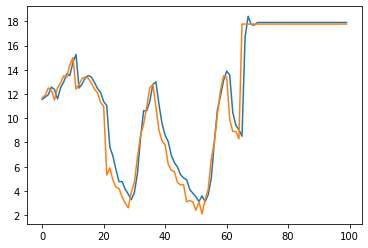

In [231]:
import matplotlib.pyplot as plt
plt.plot(test_results['Test Predictions'][0:100])
plt.plot(test_results['Actuals'][0:100])

In [232]:
#print("Mean Squared Error for LSTM model on test data:",losses.MeanSquaredError(y_test1, test_predictions))

Model 2: Convolutional Neural Networks

In [233]:
model2 = Sequential()
model2.add(InputLayer((5, 1)))
model2.add(Conv1D(64, kernel_size=2))
model2.add(Flatten())
model2.add(Dense(8, 'relu'))
model2.add(Dense(1, 'linear'))

model2.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 4, 64)             192       
                                                                 
 flatten_1 (Flatten)         (None, 256)               0         
                                                                 
 dense_10 (Dense)            (None, 8)                 2056      
                                                                 
 dense_11 (Dense)            (None, 1)                 9         
                                                                 
Total params: 2,257
Trainable params: 2,257
Non-trainable params: 0
_________________________________________________________________


In [234]:
#optimizer= Adam
cp2 = ModelCheckpoint('model2/', save_best_only=True)
model2.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=0.0001), metrics=[RootMeanSquaredError()])

In [235]:
model2.fit(X_train1, y_train1, validation_data=(X_val1, y_val1), epochs=15, callbacks=[cp2])

Epoch 1/15
155/157 [============================>.] - ETA: 0s - loss: 145.1078 - root_mean_squared_error: 12.0461INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


157/157 [==============================] - 2s 7ms/step - loss: 144.0874 - root_mean_squared_error: 12.0036 - val_loss: 6.8038 - val_root_mean_squared_error: 2.6084
Epoch 2/15
141/157 [=========================>....] - ETA: 0s - loss: 13.0058 - root_mean_squared_error: 3.6064INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


157/157 [==============================] - 1s 6ms/step - loss: 12.8763 - root_mean_squared_error: 3.5884 - val_loss: 4.3197 - val_root_mean_squared_error: 2.0784
Epoch 3/15
147/157 [===========================>..] - ETA: 0s - loss: 11.2772 - root_mean_squared_error: 3.3582INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


157/157 [==============================] - 1s 6ms/step - loss: 11.2630 - root_mean_squared_error: 3.3560 - val_loss: 4.1451 - val_root_mean_squared_error: 2.0360
Epoch 4/15
153/157 [============================>.] - ETA: 0s - loss: 10.7128 - root_mean_squared_error: 3.2730INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


157/157 [==============================] - 1s 6ms/step - loss: 10.7529 - root_mean_squared_error: 3.2792 - val_loss: 3.9721 - val_root_mean_squared_error: 1.9930
Epoch 5/15
140/157 [=========================>....] - ETA: 0s - loss: 10.1690 - root_mean_squared_error: 3.1889INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


157/157 [==============================] - 1s 6ms/step - loss: 10.1792 - root_mean_squared_error: 3.1905 - val_loss: 3.7447 - val_root_mean_squared_error: 1.9351
Epoch 6/15
131/157 [========================>.....] - ETA: 0s - loss: 9.5197 - root_mean_squared_error: 3.0854INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


157/157 [==============================] - 1s 6ms/step - loss: 9.5863 - root_mean_squared_error: 3.0962 - val_loss: 3.5180 - val_root_mean_squared_error: 1.8756
Epoch 7/15
139/157 [=========================>....] - ETA: 0s - loss: 8.9673 - root_mean_squared_error: 2.9945INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


157/157 [==============================] - 1s 6ms/step - loss: 8.9648 - root_mean_squared_error: 2.9941 - val_loss: 3.3083 - val_root_mean_squared_error: 1.8189
Epoch 8/15
144/157 [==========================>...] - ETA: 0s - loss: 8.3605 - root_mean_squared_error: 2.8915INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


157/157 [==============================] - 1s 6ms/step - loss: 8.3304 - root_mean_squared_error: 2.8862 - val_loss: 3.0796 - val_root_mean_squared_error: 1.7549
Epoch 9/15
148/157 [===========================>..] - ETA: 0s - loss: 7.7228 - root_mean_squared_error: 2.7790INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


157/157 [==============================] - 1s 6ms/step - loss: 7.7022 - root_mean_squared_error: 2.7753 - val_loss: 2.8715 - val_root_mean_squared_error: 1.6946
Epoch 10/15
150/157 [===========================>..] - ETA: 0s - loss: 7.1659 - root_mean_squared_error: 2.6769INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


157/157 [==============================] - 1s 9ms/step - loss: 7.0932 - root_mean_squared_error: 2.6633 - val_loss: 2.6406 - val_root_mean_squared_error: 1.6250
Epoch 11/15
134/157 [========================>.....] - ETA: 0s - loss: 6.5650 - root_mean_squared_error: 2.5622INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


157/157 [==============================] - 1s 6ms/step - loss: 6.5127 - root_mean_squared_error: 2.5520 - val_loss: 2.4523 - val_root_mean_squared_error: 1.5660
Epoch 12/15
140/157 [=========================>....] - ETA: 0s - loss: 6.0412 - root_mean_squared_error: 2.4579INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


157/157 [==============================] - 1s 6ms/step - loss: 5.9638 - root_mean_squared_error: 2.4421 - val_loss: 2.2727 - val_root_mean_squared_error: 1.5075
Epoch 13/15
139/157 [=========================>....] - ETA: 0s - loss: 5.4323 - root_mean_squared_error: 2.3307INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


157/157 [==============================] - 1s 6ms/step - loss: 5.4528 - root_mean_squared_error: 2.3351 - val_loss: 2.1234 - val_root_mean_squared_error: 1.4572
Epoch 14/15
142/157 [==========================>...] - ETA: 0s - loss: 5.0141 - root_mean_squared_error: 2.2392INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


157/157 [==============================] - 1s 6ms/step - loss: 4.9987 - root_mean_squared_error: 2.2358 - val_loss: 1.9605 - val_root_mean_squared_error: 1.4002
Epoch 15/15
137/157 [=========================>....] - ETA: 0s - loss: 4.5939 - root_mean_squared_error: 2.1433INFO:tensorflow:Assets written to: model2/assets


INFO:tensorflow:Assets written to: model2/assets


157/157 [==============================] - 1s 6ms/step - loss: 4.5695 - root_mean_squared_error: 2.1376 - val_loss: 1.8316 - val_root_mean_squared_error: 1.3534


In [236]:
from tensorflow.keras.models import load_model
model1 = load_model('model2/')

Model 2:Predicted data using X_train1 vs data in y_train1.


In [237]:
train_predictions = model2.predict(X_train1).flatten()
train_results = pd.DataFrame(data={'Train Predictions':train_predictions, 'Actuals':y_train1})
train_results

,Train Predictions,Actuals
0,11.140107,11.2
1,11.113235,11.3
2,11.319337,10.7
3,11.073280,10.7
4,10.872781,10.3
...,...,...
4995,12.012135,12.5
4996,12.432733,12.6
4997,12.621555,12.5
4998,12.644592,13.1


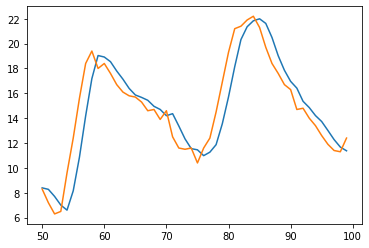

In [238]:
import matplotlib.pyplot as plt
plt.plot(train_results['Train Predictions'][50:100])
plt.plot(train_results['Actuals'][50:100])

Model 2:Predicted data using X_val1 vs data in y_val1.


In [239]:
val_predictions = model1.predict(X_val1).flatten()
val_results = pd.DataFrame(data={'Val Predictions':val_predictions, 'Actuals':y_val1})
val_results

,Val Predictions,Actuals
0,13.139549,13.3
1,13.347500,13.3
2,13.378274,12.7
3,13.047719,11.9
4,12.405939,11.8
...,...,...
495,11.750676,12.0
496,11.964827,11.2
497,11.638573,11.5
498,11.550850,11.6


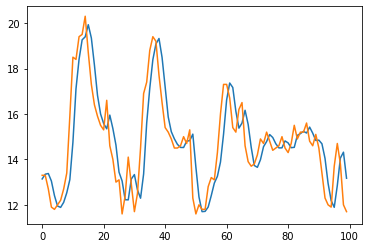

In [240]:
import matplotlib.pyplot as plt
plt.plot(val_results['Val Predictions'][0:100])
plt.plot(val_results['Actuals'][0:100])

Model 2:Predicted data using X_test1 vs data in y_test1.


In [241]:
test_predictions = model2.predict(X_test1).flatten()
test_results = pd.DataFrame(data={'Test Predictions':test_predictions, 'Actuals':y_test1})
test_results

,Test Predictions,Actuals
0,11.610478,11.7
1,11.725718,11.9
2,11.861462,12.5
3,12.287667,12.3
4,12.428235,11.5
...,...,...
2164,15.607538,21.9
2165,20.002422,24.3
2166,23.311546,26.9
2167,25.846855,28.3


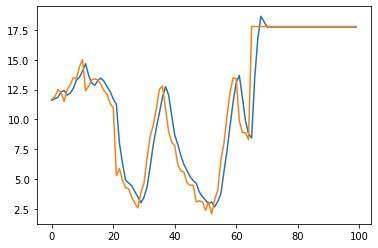

In [242]:
import matplotlib.pyplot as plt
plt.plot(test_results['Test Predictions'][0:100])
plt.plot(test_results['Actuals'][0:100])

In [243]:
#print("Mean Squared Error for Conv 1D model on test data:",mse(y_test1, test_predictions))

Final thoughts:

Both of the models were able to predict the temperatures very well based upon the given data. Aside from the biological factors such as the sun and humidity there is correlation of the temperature rising due to the effect of the pollutants, heat from the engines etc. So we are sure that with the other factors like air quality we can predict the temperature at any given time of the day.